<a href="https://colab.research.google.com/github/bcjuang/learning-representations/blob/main/mnist_image_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learning Image Representations**

**TL;DR**
* Image embeddings can be learned using an Autoencoder model (or other pretrained models' feature extractors). 
*  The learned embeddings are the vector representations of the input data. 
* Those embeddings can be used for 1) similarity search, and 2) transferred knowledge to perform downstream tasks (e.g. classification)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from datetime import datetime

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load MNIST dataset

In [4]:
trans = {
    'train': transforms.Compose([transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5), (0.5))]),
    'test': transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))]),
}


trainset = datasets.MNIST(root='/content/gdrive/MyDrive/bcj_projects/mnist', train=True,
                            download=False, transform=trans['train'])
testset = datasets.MNIST(root='/content/gdrive/MyDrive/bcj_projects/mnist', train=False,
                           download=False, transform=trans['test'])

In [5]:
from torch.utils.data import DataLoader

In [6]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size, shuffle=False)

# Build CONV autoencoder for representation learning

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False), # b, 32, 28, 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # b, 32, 14, 14
            nn.Conv2d(32, 64, 3, padding=1, bias=False), # b, 64, 14, 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # b, 64, 7, 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1, bias=False), # b, 64, 14, 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False), # b, 32, 28, 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1, bias=False), # b, 1, 28, 28
            nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [8]:
model = Autoencoder().to(device)

In [9]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,432
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
   ConvTranspose2d-9           [-1, 64, 14, 14]          65,536
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
  ConvTranspose2d-12           [-1, 32, 28, 28]          32,768
      BatchNorm2d-13           [-1, 32, 28, 28]              64
             ReLU-14           [-1, 32,

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=1e-4)

In [11]:
EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=len(trainset), epochs=EPOCHS)
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    model.train()
    for i, (imgs, labels) in enumerate(trainloader):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if (i+1) % 100 == 0:
        #     print(f'\tStep: {i+1} | Train Loss: {loss.item():.3f}')
    train_loss.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, imgs)
    val_loss.append(loss.item())
    print(f'{str(datetime.now())[:-4]} | Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss[-1]:.4f} | Val Loss: {val_loss[-1]:.4f}')

2021-02-22 06:24:13.95 | Epoch [1/20] | Train Loss: 0.0192 | Val Loss: 0.0100
2021-02-22 06:24:36.14 | Epoch [2/20] | Train Loss: 0.0132 | Val Loss: 0.0068
2021-02-22 06:24:58.29 | Epoch [3/20] | Train Loss: 0.0114 | Val Loss: 0.0065
2021-02-22 06:25:20.44 | Epoch [4/20] | Train Loss: 0.0084 | Val Loss: 0.0051
2021-02-22 06:25:43.10 | Epoch [5/20] | Train Loss: 0.0085 | Val Loss: 0.0047
2021-02-22 06:26:05.86 | Epoch [6/20] | Train Loss: 0.0070 | Val Loss: 0.0044
2021-02-22 06:26:28.70 | Epoch [7/20] | Train Loss: 0.0064 | Val Loss: 0.0042
2021-02-22 06:26:50.87 | Epoch [8/20] | Train Loss: 0.0062 | Val Loss: 0.0035
2021-02-22 06:27:13.12 | Epoch [9/20] | Train Loss: 0.0069 | Val Loss: 0.0036
2021-02-22 06:27:35.48 | Epoch [10/20] | Train Loss: 0.0062 | Val Loss: 0.0031
2021-02-22 06:27:57.99 | Epoch [11/20] | Train Loss: 0.0058 | Val Loss: 0.0046
2021-02-22 06:28:20.65 | Epoch [12/20] | Train Loss: 0.0056 | Val Loss: 0.0030
2021-02-22 06:28:42.83 | Epoch [13/20] | Train Loss: 0.0061 |

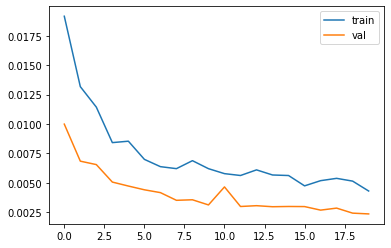

In [12]:
plt.plot(np.arange(EPOCHS), train_loss, label='train')
plt.plot(np.arange(EPOCHS), val_loss, label='val')
plt.legend()

In [13]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/bcj_projects/mnist/autoencoder.pt')

In [14]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/bcj_projects/mnist/autoencoder.pt', map_location=device))

<All keys matched successfully>

# Image reconstruction

In [15]:
im = next(iter(testloader))
test_img = im[0][:1]

## Input image

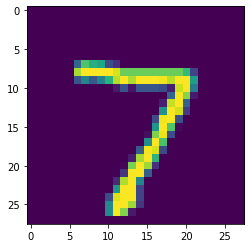

In [16]:
plt.imshow(test_img.squeeze())

## Reconstructed image by the model

In [17]:
test_img = test_img.to(device)
model.eval()
enc_output = model(test_img)

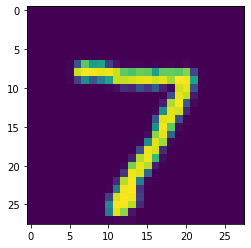

In [18]:
plt.imshow(enc_output.squeeze().cpu().detach())

# Visualize the the image embedding clusters

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2, random_state=0)

In [21]:
test_imgs = [trans['test'](np.expand_dims(im, -1)) for im in testset.data.numpy()[:1000]]
test_imgs = torch.stack(test_imgs)
test_imgs = test_imgs.to(device)
test_labels = testset.targets[:1000].numpy()

In [22]:
model.eval()
enc_outputs = model.encoder(test_imgs)

In [23]:
enc_outputs = enc_outputs.squeeze().view(test_imgs.size(0), -1).cpu().detach().numpy()

In [24]:
def tsne_plot(emb_data, labels, colors=None):
    colors = colors if colors else sns.color_palette()
    tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=100)
    new_values = tsne_model.fit_transform(emb_data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(12, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[labels[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     fontsize=12, 
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

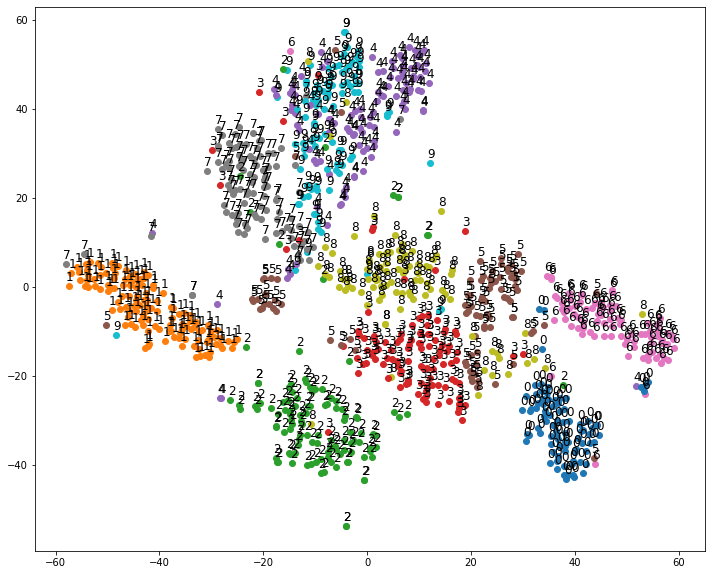

In [25]:
tsne_plot(enc_outputs, test_labels)

# Search for similar images using learned embeddings

In [26]:
# !pip install faiss-cpu

In [27]:
import faiss

In [28]:
print('test images size: ', test_imgs.size())

test_embeddings = model.encoder(test_imgs)
print('test embedding shape: ', test_embeddings.size())

test images size:  torch.Size([1000, 1, 28, 28])
test embedding shape:  torch.Size([1000, 64, 7, 7])


In [29]:
# flatten the embeddings for indexing
test_embeddings = test_embeddings.squeeze().view(test_imgs.size(0), -1).cpu().detach().numpy()
print('Flattened shape: ', test_embeddings.shape)

Flattened shape:  (1000, 3136)


## Use Flat Index and take cosine similarity

In [30]:
vector_dim = test_embeddings.shape[1]
# take inner product index
index = faiss.IndexFlatIP(vector_dim)
# normalize vectors
faiss.normalize_L2(test_embeddings)

In [31]:
# add the vectors and update the index
index.add(test_embeddings)

## Seach for top similar results based on the query image

In [32]:
n_neighbors = 7
dist, emb_idx = index.search(test_embeddings, k=n_neighbors)

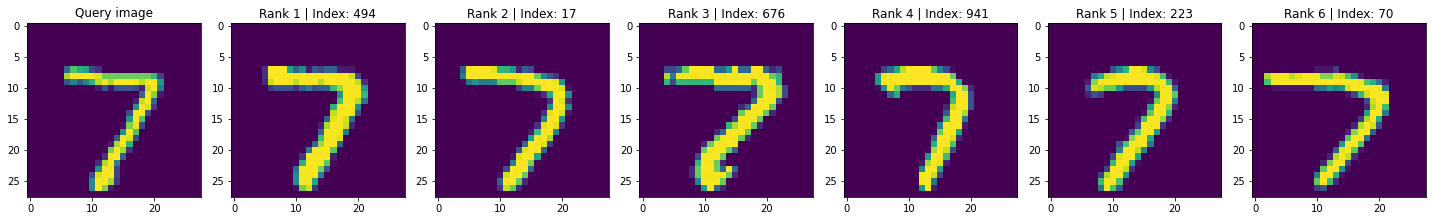

In [33]:
query_idx = 0

fig, ax = plt.subplots(1, n_neighbors, figsize=(20, 3))
for i in range(n_neighbors):
    idx = emb_idx[query_idx][i]
    ax[i].imshow(test_imgs[idx].squeeze().cpu().detach().numpy())
    ax[i].set_title('Query image' if idx ==0 else f'Rank {i} | Index: {idx}')
plt.tight_layout()

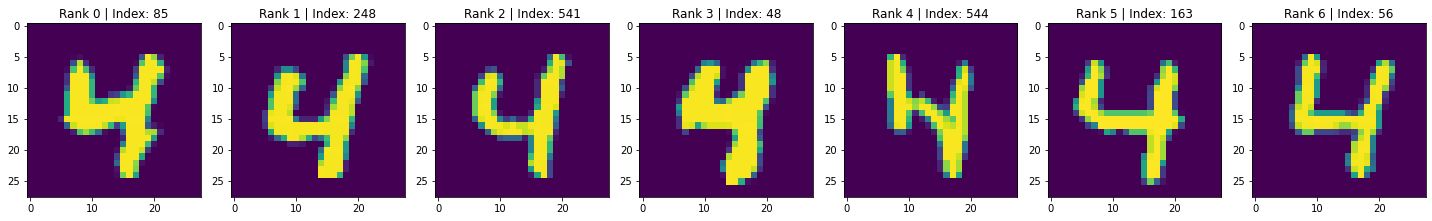

In [34]:
query_idx = 85

fig, ax = plt.subplots(1, n_neighbors, figsize=(20, 3))
for i in range(n_neighbors):
    idx = emb_idx[query_idx][i]
    ax[i].imshow(test_imgs[idx].squeeze().cpu().detach().numpy())
    ax[i].set_title('Query image' if idx ==0 else f'Rank {i} | Index: {idx}')
plt.tight_layout()

# Use the trained encoder for image classificaiton

In [35]:
import copy

In [36]:
encoder_trained = copy.deepcopy(model.encoder)

for param in encoder_trained.parameters():
    param.requires_grad = False

In [37]:
class Classifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super().__init__()
        self.features = feature_extractor
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return out

In [38]:
cls_model = Classifier(encoder_trained, 10)
cls_model.to(device)

Classifier(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cls_model.parameters(), lr=0.1, weight_decay=1e-4)

In [40]:
EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=len(trainset), epochs=EPOCHS,)

train_loss = []
val_loss = []
for epoch in range(EPOCHS):

    cls_model.train()
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cls_model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_loss.append(loss.item())
    
    total = 0
    correct = 0
    cls_model.eval()
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = cls_model(imgs)
            loss = loss_fn(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    val_loss.append(loss.item())

    print(f'{str(datetime.now())[:-4]} | Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss[-1]:.3f} | Val Loss: {val_loss[-1]:.3f} | Val Accuracy: {correct/total:.3f}')

2021-02-22 06:32:14.51 | Epoch [1/20] | Train Loss: 0.499 | Val Loss: 0.169 | Val Accuracy: 0.919
2021-02-22 06:32:34.62 | Epoch [2/20] | Train Loss: 0.645 | Val Loss: 0.115 | Val Accuracy: 0.933
2021-02-22 06:32:54.78 | Epoch [3/20] | Train Loss: 0.417 | Val Loss: 0.046 | Val Accuracy: 0.951
2021-02-22 06:33:14.53 | Epoch [4/20] | Train Loss: 0.265 | Val Loss: 0.028 | Val Accuracy: 0.954
2021-02-22 06:33:34.73 | Epoch [5/20] | Train Loss: 0.234 | Val Loss: 0.027 | Val Accuracy: 0.958
2021-02-22 06:33:54.72 | Epoch [6/20] | Train Loss: 0.430 | Val Loss: 0.022 | Val Accuracy: 0.948
2021-02-22 06:34:14.62 | Epoch [7/20] | Train Loss: 0.578 | Val Loss: 0.020 | Val Accuracy: 0.949
2021-02-22 06:34:34.17 | Epoch [8/20] | Train Loss: 0.532 | Val Loss: 0.027 | Val Accuracy: 0.936
2021-02-22 06:34:53.91 | Epoch [9/20] | Train Loss: 0.503 | Val Loss: 0.024 | Val Accuracy: 0.954
2021-02-22 06:35:14.45 | Epoch [10/20] | Train Loss: 0.682 | Val Loss: 0.011 | Val Accuracy: 0.966
2021-02-22 06:35:34